#  Titanic - Machine Learning from Disaster
### The objective of this lab is to apply machine learning techniques to the Titanic dataset to predict passenger survival

In [289]:

# importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [290]:
def wrangle(filepath):
    """
    This function reads a CSV file containing Titanic passenger data, performs data cleaning and feature engineering,
    and returns a processed DataFrame.

    Parameters:
    filepath (str): The path to the CSV file containing the Titanic passenger data.

    Returns:
    pandas.DataFrame: A DataFrame with the following columns: 'PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Family'.
    The 'Family' column is created by summing 'SibSp' and 'Parch' columns.
    Missing values in the 'Age' column are filled with the median value.
    """
    # Import CSV
    df = pd.read_csv(filepath)
    
    # Drop columns
    df = df.drop(columns=['Name', 'Ticket', 'Cabin'])
    
    # feature creation
    df['Family'] = df['SibSp'] + df['Parch']
    
    # Drop columns
    df = df.drop(columns=['SibSp', 'Parch'])
    
    # Create an imputer object with a strategy to fill missing values with the median
    imputer = SimpleImputer(strategy='median')
    df['Age'] = imputer.fit_transform(df[['Age']])
    
    return df

    

## Task 1: Data Exploration and Visualization

In [291]:
# Load the train dataset
train_data = wrangle("titanic_data/train.csv")
train_data.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Survived,Family
0,693,3,male,28.5,56.4958,S,1,0
1,482,2,male,28.5,0.0000,S,0,0
2,528,1,male,28.5,221.7792,S,0,0
3,856,3,female,18.0,9.3500,S,1,1
4,802,2,female,31.0,26.2500,S,1,2
5,653,3,male,21.0,8.4333,S,0,0
6,510,3,male,26.0,56.4958,S,1,0
7,558,1,male,28.5,227.5250,C,0,0
8,829,3,male,28.5,7.7500,Q,1,0
9,19,3,female,31.0,18.0000,S,0,1


In [292]:
# Viewing the statistical values of the training data
train_data.describe(include="all")

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Survived,Family
count,712.000000,712.000000,712,712.000000,712.000000,710,712.000000,712.000000
unique,NaN,NaN,2,NaN,NaN,3,NaN,NaN
top,NaN,NaN,male,NaN,NaN,S,NaN,NaN
freq,NaN,NaN,459,NaN,NaN,516,NaN,NaN
mean,444.405899,2.308989,NaN,29.556067,31.819826,NaN,0.383427,0.883427
std,257.465527,0.833563,NaN,13.025273,48.059104,NaN,0.486563,1.589047
min,1.000000,1.000000,NaN,0.420000,0.000000,NaN,0.000000,0.000000
25%,222.750000,2.000000,NaN,22.000000,7.895800,NaN,0.000000,0.000000
50%,439.500000,3.000000,NaN,28.500000,14.454200,NaN,0.000000,0.000000
75%,667.250000,3.000000,NaN,36.000000,31.000000,NaN,1.000000,1.000000


In [293]:
# View the data types and non-null count of the training data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Pclass       712 non-null    int64  
 2   Sex          712 non-null    object 
 3   Age          712 non-null    float64
 4   Fare         712 non-null    float64
 5   Embarked     710 non-null    object 
 6   Survived     712 non-null    int64  
 7   Family       712 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 44.6+ KB


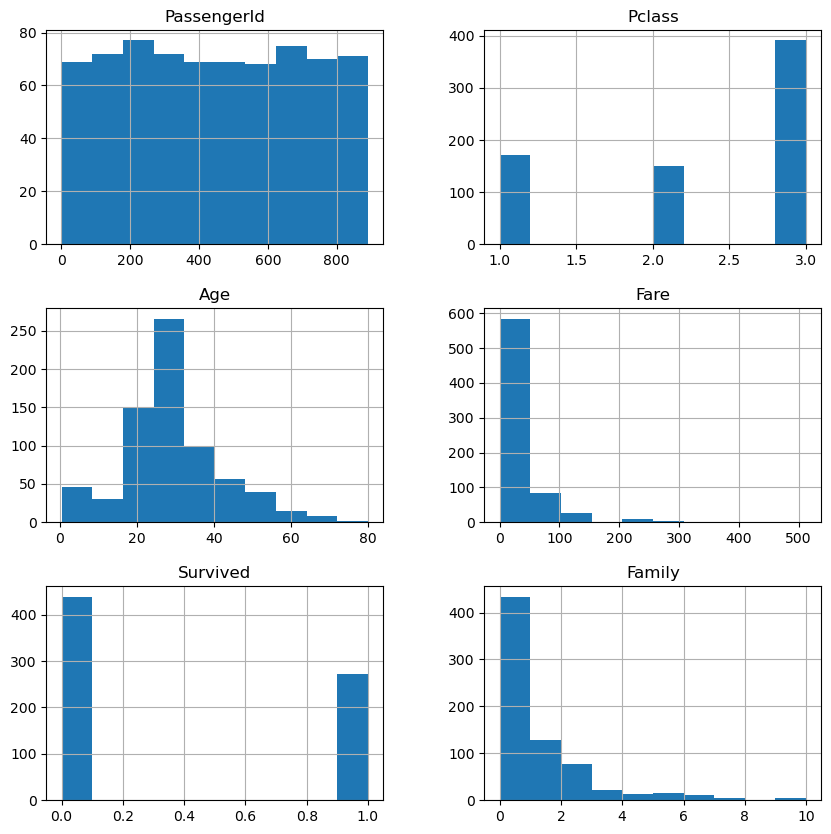

In [294]:
# Visualizing the distribution of the training data
train_data.hist(figsize=(10,10));

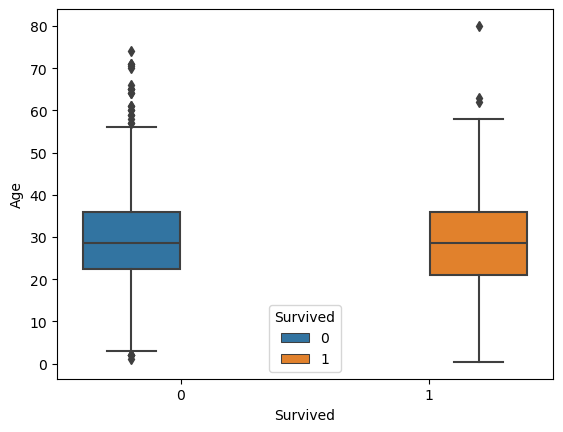

In [295]:
# Visualizing the relationships between the age and the survived column
sns.boxplot(x ='Survived',y='Age',hue='Survived', data=train_data);

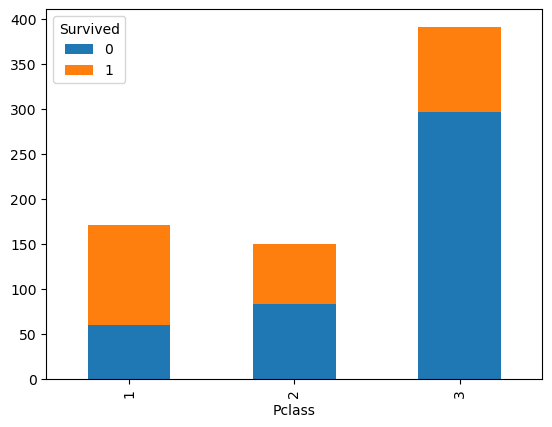

In [296]:
# Visualizing the relationships between the class and the survived column
crosstab = pd.crosstab(train_data['Pclass'], train_data['Survived'])

# Plot the stacked bar plot
crosstab.plot(kind='bar', stacked=True)
plt.show()

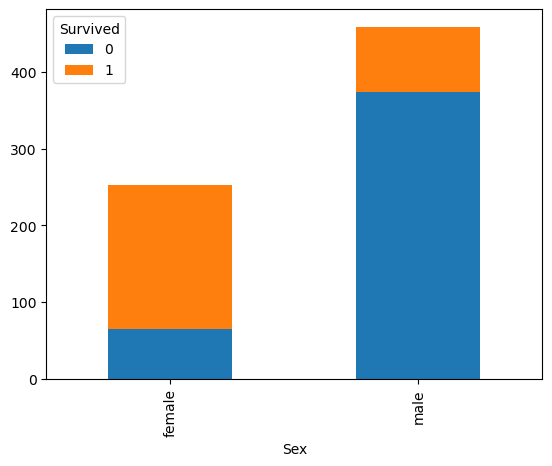

In [297]:
# Visualizing the relationships between the gender and the survived column
# Create a cross-tabulation
crosstab = pd.crosstab(train_data['Sex'], train_data['Survived'])

# Plot the stacked bar plot
crosstab.plot(kind='bar', stacked=True)
plt.show()


## Task 2: Data Cleaning and Preprocessing

In [298]:
# Checking for missing data
train_data.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
Fare           0
Embarked       2
Survived       0
Family         0
dtype: int64

In [299]:
# Fill null values in the 'Embarked' column with the mode
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

In [300]:
# Instantiate a label encoder object
le = LabelEncoder()

In [301]:
# Encoding object data types in train_data
for col in train_data.select_dtypes('object'):
    train_data[col] = le.fit_transform(train_data[col])

In [302]:
# Apply log transformation to fix skewness in the 'Fare' column
train_data['Fare'] = np.log1p(train_data['Fare'])


In [303]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = train_data['Age'].quantile(0.25)
Q3 = train_data['Age'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
train_data = train_data[(train_data['Age'] >= lower_bound) & (train_data['Age'] <= upper_bound)]

In [304]:
# Spilt the train data to features and target
X = train_data.drop(columns=['Survived'])
y = train_data['Survived']

In [305]:
# Instantiate the standard scaler 
scaler = StandardScaler()

In [306]:
# Applying Standardization to the features
X = scaler.fit_transform(X)

In [307]:
# Splitting the train data into train and validation sets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

## Task 3: Feature Engineering 

In [308]:
# Pearson correlation matrix on training data
corr = train_data.corr(method='pearson')

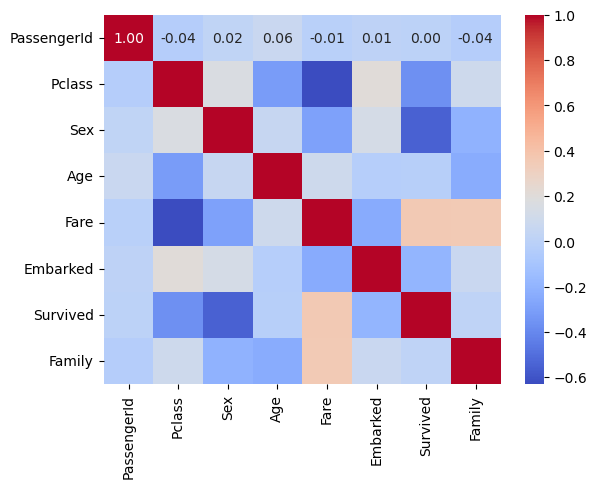

In [309]:
# Plot a heatmap of the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f");

## Task 4: Model Selection and Training

In [310]:
# Create a pipeline with an imputer, scaler, and the model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    
    #('model', RandomForestClassifier(random_state=42)) # RandomForestClassifier accuracy: 0.77
    
    ('model', SVC()) # Support Vector Machine accuracy: 0.80
    
    # ('model', LogisticRegression()) # Logistic Regression accuracy: 0.77
    
    #('model', KNeighborsClassifier()) # KNeighborsClassifier accuracy: 0.78
    
    #('model', GradientBoostingClassifier(random_state=42)) # GradientBoostingClassifier accuracy: 0.77
    
])


In [311]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('model', SVC())])

In [312]:
# Evaluate the pipeline on the test data
pipeline.score(X_val, y_val)

0.8029197080291971

In [313]:
y_pred = pipeline.predict(X_val)

In [314]:
conf = confusion_matrix(y_val, y_pred)
print(conf)

[[68 10]
 [17 42]]


In [318]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores and the mean score
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.77272727 0.83486239 0.82568807 0.83486239 0.82568807]
Mean cross-validation score: 0.818765638031693


In [315]:
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.87      0.83        78
           1       0.81      0.71      0.76        59

    accuracy                           0.80       137
   macro avg       0.80      0.79      0.80       137
weighted avg       0.80      0.80      0.80       137



## Task 5: Model Optimization 

In [316]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for SVC
param_grid_svc = {
    'model__C': [0.1, 1, 10],
    'model__gamma': ['scale', 'auto'],
    'model__kernel': ['linear', 'rbf']
}

# Instantiate the GridSearchCV object
grid_search_svc = GridSearchCV(pipeline, param_grid_svc, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search_svc.fit(X_train, y_train)

# Get the best parameters and best score
best_params_svc = grid_search_svc.best_params_
best_score_svc = grid_search_svc.best_score_

print("Best Parameters for SVC:", best_params_svc)
print("Best Cross-Validation Score for SVC:", best_score_svc)

Best Parameters for SVC: {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best Cross-Validation Score for SVC: 0.818765638031693


In [317]:
# Update the pipeline with the best parameters for Support Vector Machine
pipeline.set_params(**best_params_svc)

# Fit the updated pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = pipeline.predict(X_val)

# Evaluate the updated pipeline
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

# Print the classification report
report = classification_report(y_val, y_pred)
print(report)

Accuracy: 0.8029197080291971
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        78
           1       0.81      0.71      0.76        59

    accuracy                           0.80       137
   macro avg       0.80      0.79      0.80       137
weighted avg       0.80      0.80      0.80       137

